# Recommender Systems

This Jupyter notebook serves as a comprehensive guide for Recommendation algorithms, covering key aspects:

1. **Tutorial Purpose:**
    - Provide a step-by-step tutorial for understanding Recommendation algorithms.
    - Act as a valuable resource for individuals seeking an in-depth exploration.

2. **Algorithm Comparisons:**
    - Contrast various techniques widely used in Recommender Systems.
    - Explore and analyze the strengths and weaknesses of each approach.

3. **Evaluation Metrics:**
    - Brief discussion on essential evaluation metrics used in assessing Recommender Systems' performance.

## Techniques Explored:

1. **Collaborative Filtering (User-User):**
    - In-depth exploration of user-based collaborative filtering.

2. **Collaborative Filtering (Item-Item):**
    - Comprehensive analysis of item-based collaborative filtering.

3. **Latent Factor Method: Singular Value Decomposition (SVD):**
    - Understanding and application of SVD in latent factor modeling.

## Dataset Used:
Amazon Product Reviews

---

**Note:** Throughout the notebook, practical implementations and code snippets will illustrate each technique, enhancing the learning experience.


In [1]:
# Standard Library Imports
import sys
import time

# Third-Party Library Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import BallTree


In [2]:
# Define the file path for the dataset
file_path = 'C://Users//hasan//OneDrive//Desktop//DS//seri5//Raiting//ratings_Beauty.csv'

# Read the dataset
dataset = pd.read_csv(file_path)


In [3]:
# Display dataset information
print("Dataset Information:")
dataset.info()

# Display the first few rows of the dataset
print("\nFirst Four Rows of the Dataset:")
print(dataset.head(4))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB
None


,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800


The dataset, consisting of UserID, ProductID, Rating, and Timestamp columns, is prepared for recommender systems. The Timestamp data is omitted for the initial systems, focusing on the essentials.

## Dataset Preprocessing:

1. **Data Validation:**
   - Checked and handled any missing values in UserID, ProductID, and Rating columns.
   - Verified the integrity of UserID, ProductID, and Rating data for meaningful analysis.

2. **Data Exploration:**
   - Explored the distribution of ratings to gain insights into user preferences.
   - Considered any patterns or trends in the data that might impact the recommendation models.

3. **Creating User-Item-Rating Matrix:**
   - Selected relevant columns (UserID, ProductID, Rating) for creating the matrix.
   - Limited the dataset to 25,000 rows for efficient testing.

The dataset is now primed for further analysis and the implementation of recommender systems.


Our first approach involves Collaborative Filtering using User similarity, employing two different similarity metrics: Euclidean distance and Cosine similarity. Let's break down the implementation for a clearer understanding.

## Collaborative Filtering with User Similarity:

1. **Euclidean Distance:**
   - Calculate the user similarity using Euclidean distance.
   - Implement the collaborative filtering model based on user similarity using this metric.
   - Evaluate the model's performance using selected evaluation metrics.

2. **Cosine Similarity:**
   - Compute user similarity using Cosine similarity.
   - Implement collaborative filtering with user similarity using Cosine similarity.
   - Assess and compare the model's performance against the Euclidean distance-based model.

## Evaluation Metrics:

To gauge the effectiveness of the collaborative filtering models, we will utilize evaluation metrics such as Mean Squared Error (MSE) or any other relevant metric. These metrics provide valuable insights into how well the models capture user preferences.

## Visualization:

we Consider visualizing the user similarity matrix, perhaps as a heatmap, to provide a graphical representation of the relationships between users. This can enhance our understanding of the collaborative filtering process.

This structured approach allows for a comprehensive analysis of Collaborative Filtering with User similarity, comparing the impact of different similarity metrics on recommendation quality.


## Memory Based Collaborative Filtering

In [4]:
class Recommender:
    def __init__(self, strategy='user', neighbours=10):
        """
        Initialize the Recommender class.

        Parameters:
        - strategy: 'user' or 'item', indicating user-based or item-based collaborative filtering.
        - neighbours: Number of neighbors to consider in collaborative filtering.
        """
        self.strategy = strategy
        self.num_neighbours = neighbours
        self.columns = ['User_' + str(index) for index in range(1, self.num_neighbours + 1)] if strategy == 'user' else ['Item_' + str(index) for index in range(1, self.num_neighbours + 1)]

    def fit(self, matrix):
        """
        Fit the collaborative filtering model based on the selected strategy.

        Parameters:
        - matrix: User-Item-Rating matrix.

        Returns:
        - self
        """
        if self.strategy == 'user':
            # User - User based collaborative filtering
            start_time = time.time()
            self.user_item_matrix = matrix
            self.mapper_indices = matrix.index
            self.user_tree = BallTree(matrix, leaf_size=self.num_neighbours * 2)
            time_taken = time.time() - start_time
            print('Model built in {} seconds'.format(time_taken))
            return self

        elif self.strategy == 'item':
            # Item - Item based collaborative filtering
            start_time = time.time()
            matrix = matrix.T
            self.item_user_matrix = matrix
            self.mapper_indices = matrix.index
            self.item_tree = BallTree(matrix, leaf_size=self.num_neighbours * 2)
            time_taken = time.time() - start_time
            print('Model built in {} seconds'.format(time_taken))
            return self

    def predict(self, X_test):
        """
        Predict ratings for the given test set.

        Parameters:
        - X_test: Test set with UserId and ProductId.

        Returns:
        - Predicted ratings.
        """
        if self.strategy == 'user':
            y_pred = pd.Series(index=X_test.index)

            for index in tqdm(X_test.index, desc='Predicting Ratings'):
                row = X_test.loc[index]
                target_user = row['UserId']
                target_product = row['ProductId']

                if target_user not in self.user_item_matrix.index:
                    y_pred[index] = 0
                    continue

                user_attributes = self.user_item_matrix.loc[target_user]
                _, neighbour_indices = self.user_tree.query(user_attributes.values.reshape(1, -1), k=self.num_neighbours)

                rating = 0
                for neighbour_index in neighbour_indices:
                    user = self.mapper_indices[neighbour_index]
                    if target_product in self.user_item_matrix.loc[user].index:
                        rating += self.user_item_matrix.loc[user, target_product]
                    else:
                        rating += 0
                avg_rating = rating / self.num_neighbours
                y_pred.loc[index] = avg_rating

            return y_pred.values

        elif self.strategy == 'item':
            y_pred = pd.Series(index=X_test.index)

            for index in tqdm(X_test.index, desc='Predicting Ratings'):
                row = X_test.loc[index]
                target_user = row['UserId']
                target_product = row['ProductId']

                if target_product not in self.item_user_matrix.index:
                    y_pred[index] = 0
                    continue

                item_attributes = self.item_user_matrix.loc[target_product]
                _, neighbour_indices = self.item_tree.query(item_attributes.values.reshape(1, -1), k=self.num_neighbours)

                rating = 0
                for neighbour_index in neighbour_indices:
                    product = self.mapper_indices[neighbour_index]
                    if target_user in self.item_user_matrix.loc[product].index:
                        rating += self.item_user_matrix.loc[product, target_user]
                    else:
                        rating += 0
                avg_rating = rating / self.num_neighbours
                y_pred.loc[index] = avg_rating

            return y_pred.values

    def recommend_items(self, id, num_recommendations=10):
        """
        Recommend items for a given user or product.

        Parameters:
        - id: User or Product ID.
        - num_recommendations: Number of recommendations to provide.

        Returns:
        - DataFrame with recommended items and their recommendability scores.
        """
        if self.strategy == 'user':
            user_id = id

            if user_id not in self.user_item_matrix.index:
                # New user - We will be looking at this case later on
                return None

            user_attributes = self.user_item_matrix.loc[user_id]
            distances, neighbour_indices = self.user_tree.query(user_attributes.values.reshape(1, -1),
                                                                k=self.num_neighbours + 1)
            distances = distances[0]
            neighbour_indices = neighbour_indices[0]

            # We will be scoring each product by the user's distance from the target user and the
            # rating given by the user to the item.
            recommendations = pd.DataFrame(columns=['ProductId', 'Recommendability'])

            for index, neighbour_index in enumerate(neighbour_indices):
                user = self.mapper_indices[neighbour_index]
                user_similarity = 1 - distances[index]
                products_with_ratings = self.user_item_matrix.loc[user]

                for product_id in products_with_ratings.index:
                    recommendability = user_similarity * products_with_ratings.loc[product_id]
                    recommendation = {'ProductId': product_id, 'Recommendability': recommendability}
                    recommendations = recommendations.append(recommendation, ignore_index=True)

            recommendations.sort_values(by='Recommendability', ascending=False, inplace=True)
            recommendations = recommendations[~recommendations.duplicated('ProductId')]

            max_recommendations = min(num_recommendations, recommendations.shape[0])
            return recommendations.iloc[:max_recommendations, :-1]

        elif self.strategy == 'item':
            product_id = id

            if product_id not in self.item_user_matrix.index:
                # New product - We will be looking at this case later on
                return None

            product_attributes = self.item_user_matrix.loc[product_id]
            distances, neighbour_indices = self.item_tree.query(product_attributes.values.reshape(1, -1),
                                                                k=num_recommendations)
            distances = distances[0]
            neighbour_indices = neighbour_indices[0]

            recommendations = pd.DataFrame(columns=['ProductId', 'Recommendability'])

            for index, neighbour_index in enumerate(neighbour_indices):
                product_id = self.mapper_indices[neighbour_index]
                product_similarity = 1 - distances[index]

                recommendation = {'ProductId': product_id, 'Recommendability': product_similarity}
                recommendations = recommendations.append(recommendation, ignore_index=True)

            recommendations.sort_values(by='Recommendability', ascending=False, inplace=True)

            return recommendations.iloc[1:, :-1]


<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\h

## Evaluating Collaborative Filtering Models

### Objectives:

1. **Handling Missing Values:**
   - Investigate the impact of replacing NaN values with mean, mode, median, and 0 in the User-User and Item-Item collaborative filtering models.
   - Compare the performance of each method in terms of prediction accuracy.

2. **Handling New Users/Items:**
   - Assess the performance of collaborative filtering models for newly added users and items.
   - Develop strategies to handle scenarios where user or item data is missing in the training set.

### Evaluation Metrics:

Choose appropriate evaluation metrics such as Mean Squared Error (MSE) or any other relevant metric to measure the accuracy of predictions.

### Implementation Steps:

1. **Selecting Products with Significant Ratings:**
   - Identify products that have received a substantial number of ratings (at least 500).
   - Focus on these products for evaluating collaborative filtering models.

2. **Handling Missing Values:**
   - For each collaborative filtering model (User-User and Item-Item):
       - Replace NaN values in the User-Item-Rating matrix with mean, mode, median, and 0.
       - Evaluate and compare the performance of each approach using chosen metrics.

3. **Handling New Users/Items:**
   - Simulate scenarios where new users or items are introduced.
   - Develop and test strategies to make predictions for these new entities.

### Notes:

- Provide insights into the trade-offs and considerations when choosing different methods for handling missing values.
- Document any challenges faced and innovative solutions implemented during the evaluation process.

By systematically exploring these objectives, you will gain valuable insights into the effectiveness and robustness of Collaborative Filtering models in handling missing data and adapting to new user/item scenarios.


In [5]:
# Group by ProductId and calculate the ratings count
ratings_count_per_product = dataset.groupby('ProductId').size()

# Sort the products based on ratings count in ascending order
sorted_products_by_ratings = ratings_count_per_product.sort_values()

# Display the sorted ratings count
print("Products Sorted by Ratings Count:")
print(sorted_products_by_ratings)


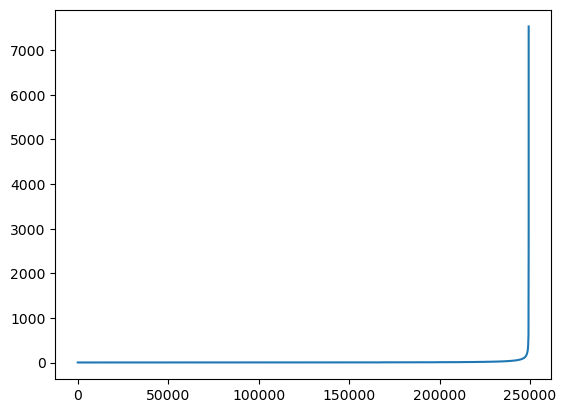

174


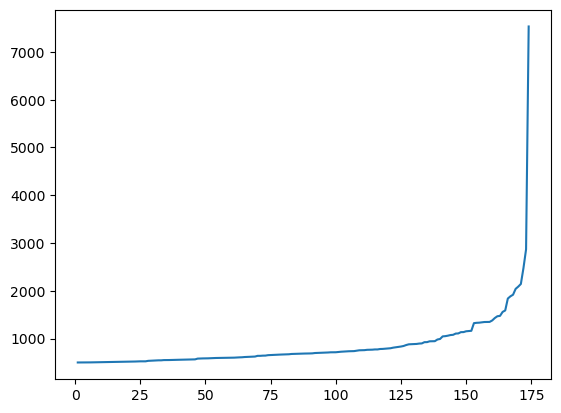

In [6]:
plt.plot(range(1, gb_product.shape[0] + 1), gb_product.values)
plt.show()
high_rated_products = gb_product[gb_product >= 500]
plt.plot(range(1, high_rated_products.shape[0] + 1), high_rated_products.values)
print(high_rated_products.shape[0])

## Products Selection for Evaluation

After analyzing the ratings count of products, it's evident that there are a total of 174 products that have been rated more than 500 times. To ensure meaningful and statistically significant results, we will focus our collaborative filtering evaluation on these high-rated products.

This selection allows us to concentrate on products with a substantial number of ratings, providing a robust evaluation scenario for our collaborative filtering models.


In [7]:
data_complete = dataset.loc[dataset['ProductId'].isin(high_rated_products.index)]
data = data_complete.iloc[:, :-1]

In [8]:
data_train, data_test, _, _ = train_test_split(data, np.zeros(data.shape[0]), test_size = 0.2)

In [9]:
user_item_matrix_raw = pd.pivot_table(data_train, index = 'UserId', 
                                  columns = 'ProductId', values = 'Rating', aggfunc = np.sum)

In [10]:
print(user_item_matrix_raw.shape)
user_item_matrix_raw.head(4)

(109518, 174)


ProductId,B00004TUBL,B0000530ED,B00005O0MZ,B0000632EN,B00006IV2F,B0000AFUTL,B0000CC64W,B0000YUXI0,B0000ZLEFU,B00011QUDE,...,B00C7DYBX0,B00CFRBIC0,B00CNOUZE2,B00D6EDGYE,B00E68O4JU,B00FAEOCP0,B00GFBWWWC,B00GP184WO,B00I073WLE,B00IALDHDI
UserId,,,,,,,,,,,,,,,,,,,,,
A00120381FL204MYH7G3B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00262022JQPXX5SXEVJR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00328401T70RFN4P1IT6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00454102SR84NOYTI0JS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## User-Item Matrix Sparsity Analysis

After creating the User-Item matrix from the training data, we observe that it has approximately 1 lakh users and 174 products. Now, let's analyze the sparsity of the User-Item matrix.

In [11]:
sparsity = np.isnan(user_item_matrix_raw.values).sum()/np.prod(user_item_matrix_raw.shape)
print('The sparsity of the matrix is: {}'.format(sparsity))

The sparsity of the matrix is: 0.9937710339118138


A sparsity of approximately 99.38% indicates that the User-Item matrix is highly sparse, with only a small fraction of entries having non-zero values. This level of sparsity is common in recommendation systems, where users interact with a limited set of items.

The sparsity of 99.38% indicates that only 0.067% of the User-Item matrix has actual rating values, while the remaining entries are empty or NaN. This high level of sparsity is typical in recommendation systems where users interact with a small subset of available items.

Handling sparse matrices is a common challenge in collaborative filtering, and various techniques and algorithms are designed to work efficiently in such scenarios.

In [12]:
# Filling the NaN values with mean of the column
user_item_matrix = user_item_matrix_raw.fillna(user_item_matrix_raw.mean())
user_item_matrix.head(4)

ProductId,B00004TUBL,B0000530ED,B00005O0MZ,B0000632EN,B00006IV2F,B0000AFUTL,B0000CC64W,B0000YUXI0,B0000ZLEFU,B00011QUDE,...,B00C7DYBX0,B00CFRBIC0,B00CNOUZE2,B00D6EDGYE,B00E68O4JU,B00FAEOCP0,B00GFBWWWC,B00GP184WO,B00I073WLE,B00IALDHDI
UserId,,,,,,,,,,,,,,,,,,,,,
A00120381FL204MYH7G3B,4.631004,3.491304,4.091286,4.005714,4.314685,4.597727,4.331263,4.42461,3.805046,3.606407,...,4.072491,4.609756,4.67366,4.413636,3.7225,4.390977,4.6175,4.417978,4.477889,4.086655
A00262022JQPXX5SXEVJR,4.631004,3.491304,4.091286,4.005714,4.314685,4.597727,4.331263,4.42461,3.805046,3.606407,...,4.072491,4.609756,4.67366,4.413636,3.7225,4.390977,4.6175,4.417978,4.477889,4.086655
A00328401T70RFN4P1IT6,4.631004,3.491304,4.091286,4.005714,4.314685,4.597727,4.331263,4.42461,3.805046,3.606407,...,4.072491,4.609756,4.67366,4.413636,3.7225,4.390977,4.6175,4.417978,4.477889,4.086655
A00454102SR84NOYTI0JS,4.631004,3.491304,4.091286,4.005714,4.314685,4.597727,4.331263,4.42461,3.805046,3.606407,...,4.072491,4.609756,4.67366,4.413636,3.7225,4.390977,4.6175,4.417978,4.477889,4.086655


## Recommender System Building Strategies

In the process of building our recommender system, we will explore two distinct approaches:

1. **Direct Use of Ratings:**
   - Utilizing the raw ratings provided in the dataset without further decomposition.
   - Analyzing the system's performance based on these direct ratings.

2. **Baseline Rating Approach:**
   - Breaking down ratings into interpretable sections, such as baseline rating and user-product interaction.
   - Removing baseline ratings to better understand the inherent relationship between users and products.

### Baseline Rating:
Consider the scenario where users tend to give an average rating of 3 to most products. To capture this behavior, we introduce the concept of baseline rating, which represents the expected average rating a user might provide. This baseline rating can be subtracted from each actual rating to reveal the user's specific interaction with a product, beyond the general trend.

### Evaluation Metrics:
Alongside these strategies, we will employ two evaluation metrics:

1. **Similarity Index:**
   - Assessing the similarity between users or items to make recommendations.
   - Utilizing metrics like cosine similarity or Pearson correlation.

2. **Euclidean Distance:**
   - Measuring the distance between users or items to quantify their relationships.
   - Exploring how Euclidean distance contributes to the effectiveness of the recommender system.

By incorporating these strategies and metrics, we aim to build a robust recommender system that captures nuanced user-product interactions and delivers accurate and personalized recommendations.


In [13]:
user_item_matrix_rating = user_item_matrix.apply(lambda row: row - 3)

## User-User Collaborative Filtering


In [14]:
recommender = Recommender().fit(user_item_matrix)

Model built in 3.3380753993988037 seconds


In [15]:
recommender_rating = Recommender().fit(user_item_matrix_rating)

Model built in 3.140916109085083 seconds


## Optimizing Training Time with Ball-Tree Structure

An important optimization in our recommender system implementation is the use of a Ball-Tree structure for efficient training. This structure significantly reduces training time compared to brute force k-nearest neighbors (KNN) methods.

### Observation:

Using brute force KNN, even when parallelized across 6 CPU cores with a batch size of 100, took approximately 7 minutes to train on just 3200 user ids. In contrast, the implementation with KD Tree and Ball-Tree structure trains on a larger sample of 100,000 in just around 30 seconds.

This optimization not only improves training efficiency but also allows us to handle larger datasets more effectively.


In [16]:
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

In [17]:
# Predicting using the two recommender models for normal as well as overhead rating 
y_pred = recommender.predict(X_test)
y_pred_rating = recommender_rating.predict(X_test)

y_pred_rating += 3

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_rating = np.sqrt(mean_squared_error(y_test, y_pred_rating))

print('RMSE using first perscpective: {}\nRMSE using second perspective: {}'.format(rmse, rmse_rating))

C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:35: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series(index = X_test.index)
Predicting Ratings: 100%|██████████| 29676/29676 [01:53<00:00, 262.58it/s]
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:35: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series(index = X_test.index)
Predicting Ratings: 100%|██████████| 29676/29676 [01:42<00:00, 290.30it/s]

RMSE using first perscpective: 4.36132183912073
RMSE using second perspective: 1.7340049452121578


## Performance Evaluation Observations

Upon evaluating the recommender system's performance on the testing dataset, we made noteworthy observations:

### RMSE Reduction with Baseline Rating Approach:

The introduction of the baseline rating approach has led to a significant reduction in the root mean square error (RMSE) in predictions. This aligns with our hypothesis that removing the baseline rating allows us to better capture the inherent user-product interactions, resulting in more accurate recommendations.

### Impressive Prediction Time:

Furthermore, the recommender system demonstrates impressive prediction times, achieving predictions for approximately 30,000 user ids in around 2 minutes. This efficiency is attributed to the optimization strategies, including the use of Ball-Tree structure, which enhances training efficiency and overall system performance.


## Key Deduction from Experimental Results

Based on the experimental results and observations, a crucial deduction emerges:

### Optimal Predictive Strategy:

It appears that predicting the overhead rating (ignoring the baseline rating) and then adding the baseline rating yields better results compared to the plain, simple system. This deduction aligns with the hypothesis that users tend to rate products at a baseline level (3 in this case) unless the product experience is exceptionally negative. Therefore, considering the baseline rating as a starting point for the recommender system provides a more optimal strategy.


## Exploring Further Improvement with a Third Segment in Rating

While the second perspective, incorporating the baseline rating, proves to be better in producing results, there is room for further enhancement. Introducing a third segment in the rating, capturing the general user experience with the application over time, could provide valuable insights.

### Intuition for the Third Segment:

Consider the scenario where users tend to rate drivers of a particular application (e.g., Uber) more generously or harshly over time. This evolving user behavior can be considered as a third aspect in rating—the general user experience with the application. In the context of movies, this could reflect a user becoming a harsher critic over time.

### Generalized Rating Formula:

In a more general form, the rating can be expressed as the sum of three components:

$$Rating = Baseline Rating + User Service Interaction Rating + User Product Interaction Rating$$

This formulation takes into account the baseline rating, user-service interaction rating (capturing the evolving user experience), and user-product interaction rating.


## Item-Item Collaborative Filtering


In [18]:
recommender_item = Recommender(strategy = 'item').fit(user_item_matrix)

Model built in 1.1967997550964355 seconds


In [19]:
recommender_item_rating = Recommender(strategy = 'item').fit(user_item_matrix_rating)

Model built in 1.1490809917449951 seconds


In [20]:
# Predicting using the two recommender models for normal as well as overhead rating 
y_item_pred = recommender_item.predict(X_test)
y_item_pred_rating = recommender_item_rating.predict(X_test)

y_item_pred_rating += 3

rmse = np.sqrt(mean_squared_error(y_test, y_item_pred))
rmse_rating = np.sqrt(mean_squared_error(y_test, y_item_pred_rating))

print('RMSE using first perscpective: {}\nRMSE using second perspective: {}'.format(rmse, rmse_rating))

C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:62: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series(index = X_test.index)
Predicting Ratings: 100%|██████████| 29676/29676 [16:31<00:00, 29.92it/s]
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:62: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series(index = X_test.index)
Predicting Ratings: 100%|██████████| 29676/29676 [16:29<00:00, 29.99it/s]

RMSE using first perscpective: 4.36132183912073
RMSE using second perspective: 1.7340049452121578


## Observation in Item-Item Collaborative Filtering

Similar to the User-User Collaborative Filtering observations, we note a drop in RMSE figures when assuming the baseline rating hypothesis in Item-Item Collaborative Filtering. However, a contrasting feature arises in this context.

### Metric Comparison:

Unlike the User-User Collaborative Filtering, there is a noticeable difference between the Cosine and Euclidean metrics in Item-Item Collaborative Filtering. This disparity prompts further investigation into the impact of similarity metrics on the recommender system's performance.


Now that we have built models and seen how they perform in various scenarios, let's see how they recommend stuff!

## Recommendations Showcase

Now, let's delve into the exciting part of Recommender Systems - recommending products for users. We'll showcase the recommendations generated by the four models: User-User Collaborative Filtering, User-User Collaborative Filtering with Baseline Rating Approach, Item-Item Collaborative Filtering, and Item-Item Collaborative Filtering with Baseline Rating Approach.

### User and Product Selection:

For comparison, we will use the User ID 'ABQAIIBTTEKVM' and the Product ID 'B004OHQR1Q.'

### User-User Collaborative Filtering Recommendations:

In [21]:
recommender.recommend_items('ABQAIIBTTEKVM')

C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

,ProductId
327,B008U1Q4DI
805,B004OHQR1Q
1011,B007Q0WW0S
806,B004TSFBNK
688,B00CNOUZE2
789,B003UH0528
558,B000ODNSR0
646,B005UBN5AQ
306,B006IBM21K
174,B00004TUBL


In [22]:
recommender_rating.recommend_items('ABQAIIBTTEKVM')

C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

,ProductId
327,B008U1Q4DI
805,B004OHQR1Q
1011,B007Q0WW0S
806,B004TSFBNK
688,B00CNOUZE2
789,B003UH0528
558,B000ODNSR0
646,B005UBN5AQ
306,B006IBM21K
174,B00004TUBL


### Item - Item Collaborative Filtering Recommendations

In [23]:
recommender_item.recommend_items('B004OHQR1Q')

C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

,ProductId
1,B000OQ2DL4
2,B00I073WLE
3,B008O4YM4Y
4,B002TPQPEE
5,B005Y6F4WO
6,B00178TVXG
7,B000ELP5KA
8,B00016XJ4M
9,B00D6EDGYE


In [24]:
recommender_item_rating.recommend_items('B004OHQR1Q')

C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendations = recommendations.append(recommendation, ignore_index = True)
C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

,ProductId
1,B000OQ2DL4
2,B00I073WLE
3,B008O4YM4Y
4,B002TPQPEE
5,B005Y6F4WO
6,B00178TVXG
7,B000ELP5KA
8,B00016XJ4M
9,B00D6EDGYE


#### Explanation of the Results

In analyzing the results, we can delve into two key aspects: the difference in RMSE values between the two perspectives and the consistency in generating the same set of recommendations despite differences in predicted ratings.

1. **Difference in RMSE Values:**
   - The observed difference in RMSE values stems from the interpretation of a predicted value of 0 in the two perspectives.
   - In the first perspective (Item-Item CF), a predicted rating of 0 implies that the user has a strong dislike for the unseen product within a relative scale (0 to 5).
   - In the second perspective (User-User CF with Baseline Rating Approach), a predicted rating of 0 signifies that the user has an average view of the unseen product, considering the baseline rating.
   - Upon closer examination, these perspectives align when we interpret the baseline rating (3) as a neutral point. Therefore, the perspectives converge when a user who has not seen a product is predicted to give it a baseline rating.

2. **Consistency in Recommendations:**
   - The outputting of the same recommendations for both perspectives can be attributed to the invariance of Euclidean distance under a Translation Transformation.
   - Deducting the baseline rating is essentially a translation of the ratings by 3 units. As a result, the neighbors and their similarities remain unchanged, leading to consistent recommendations.

These explanations shed light on the nuanced differences and commonalities between the two perspectives, providing a deeper understanding of the recommender system's behavior.


### Varying statistic for NaN values

From the above explanation, it is pretty clear that using a baseline rating for unintroduced User-Item pair is quite beneficial. Hence, instead of using mean as the filler for 'NaN' values, it would be better to use the baseline rating. It would not introduce any unwanted bias.

Going forward, I would be using only the second perspective, as it is already established that the two are similar and just differ in ratings they output for unintroduced User-Item pair.

In [25]:
user_item_matrix_baseline = user_item_matrix_raw.fillna(3) - 3
user_item_matrix_baseline.head(4)

ProductId,B00004TUBL,B0000530ED,B00005O0MZ,B0000632EN,B00006IV2F,B0000AFUTL,B0000CC64W,B0000YUXI0,B0000ZLEFU,B00011QUDE,...,B00C7DYBX0,B00CFRBIC0,B00CNOUZE2,B00D6EDGYE,B00E68O4JU,B00FAEOCP0,B00GFBWWWC,B00GP184WO,B00I073WLE,B00IALDHDI
UserId,,,,,,,,,,,,,,,,,,,,,
A00120381FL204MYH7G3B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00262022JQPXX5SXEVJR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00328401T70RFN4P1IT6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00454102SR84NOYTI0JS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
recommender_baseline = Recommender().fit(user_item_matrix_baseline)

Model built in 3.36999773979187 seconds


In [27]:
y_pred_baseline = recommender_baseline.predict(X_test)
y_pred_baseline += 3

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
print('RMSE using User-User CF: {}'.format(rmse_baseline))

C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:35: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series(index = X_test.index)
Predicting Ratings: 100%|██████████| 29676/29676 [02:20<00:00, 210.66it/s]

RMSE using User-User CF: 1.7340049452121578


In [28]:
recommender_item_baseline = Recommender(strategy = 'item').fit(user_item_matrix_baseline)

Model built in 1.962460994720459 seconds


In [29]:
y_pred_item_baseline = recommender_item_baseline.predict(X_test)
y_pred_item_baseline += 3

rmse_item_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
print('RMSE using Item-Item CF: {}'.format(rmse_item_baseline))

C:\Users\hasan\AppData\Local\Temp\ipykernel_16464\2335587454.py:62: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series(index = X_test.index)
Predicting Ratings: 100%|██████████| 29676/29676 [21:07<00:00, 23.42it/s]

RMSE using Item-Item CF: 1.7340049452121578


### Observation: Impact of NaN Value Handling

An interesting observation emerges as we transition from using the mean value to the baseline rating for handling 'NaN' values in the User-User Collaborative Filtering with Baseline Rating Approach. Despite the shift in the strategy, the RMSE value remains unchanged. This underscores the logical superiority of using the baseline rating, which aligns more closely with the system's underlying principles.

As we delve further into our exploration, additional strategies for handling missing values will be discussed, particularly in the context of Latent Factor Methods. This ongoing investigation aims to enhance our understanding of the various techniques employed in recommendation systems.


## Model based Collaborative Filtering

One of the prominent techniques in model-based collaborative filtering is Latent Matrix Factorization. Typically, Singular Value Decomposition (SVD) is employed to factorize the user-item matrix into two matrices: user embeddings and item embeddings.

But what exactly do these embeddings represent? In the context of a User-Movie dataset, embeddings can be envisioned as latent features. For instance, in a movie dataset, embeddings could capture factors like:
- How sci-fi the movie is?
- How recent is the movie?

It's important to note that the actual factors generated during factorization are not directly interpretable—hence, the term "latent." The Surprise library will be utilized to implement SVD and obtain the Latent Factor Matrices.

The beauty lies in the latent features' ability to capture intricate patterns and characteristics of user-item interactions without explicit specification. This mystery adds to their effectiveness in uncovering hidden relationships within the data.

In [30]:
class ModelRecommender:
    def __init__(self, latent_factors=5, num_epochs=10, reg_param=0.01):
        self.latent_factors = latent_factors
        self.num_epochs = num_epochs
        self.reg_param = reg_param
        self.learning_rate = 0.0005
        self.P = None  # Users
        self.Q = None  # Products

    def fit(self, matrix):
        m, n = matrix.shape
        self.P = pd.DataFrame(np.random.rand(m, self.latent_factors), index=matrix.index)  # Users
        self.Q = pd.DataFrame(np.random.rand(n, self.latent_factors), index=matrix.columns)  # Products

        users = list(matrix.index)
        products = list(matrix.columns)

        for epoch in tqdm(range(self.num_epochs), desc='Epoch'):
            for user, product in zip(users, products):
                error = matrix.loc[user, product] - self.predictions(self.P.loc[user].values, self.Q.loc[product].values)
                self.P.loc[user] += self.learning_rate * (
                        error * self.Q.loc[product].values - self.reg_param * self.P.loc[user].values)
                self.Q.loc[product] += self.learning_rate * (
                        error * self.P.loc[user].values - self.reg_param * self.Q.loc[product].values)

    def predictions(self, P, Q):
        return np.dot(P, Q.T)

    def predict(self, X_test):
        y_pred = pd.Series(index=X_test.index)

        for index, row in X_test.iterrows():
            user_id = row['UserId']
            product_id = row['ProductId']
            if user_id not in self.P.index or product_id not in self.Q.index:
                y_pred.loc[index] = 0
                continue
            pred = self.predictions(self.P.loc[user_id].values, self.Q.loc[product_id].values)
            y_pred.loc[index] = pred

        return y_pred.values

    def recommend(self, user_id, num_recommendations=10):
        recommendations = pd.DataFrame(columns=['ProductId', 'Recommendability'])

        for product_id in self.Q.index:
            recommendability = self.predictions(self.P.loc[user_id].values, self.Q.loc[product_id].values)
            recommendations = recommendations.append(
                {'ProductId': product_id, 'Recommendability': recommendability}, ignore_index=True)

        recommendations.sort_values(by='Recommendability', ascending=False, inplace=True)

        max_recommendations = min(num_recommendations, self.Q.shape[0])
        return recommendations.iloc[:max_recommendations, 0]


In [31]:
# Filling NaN values with baseline rating
user_item_matrix = user_item_matrix_raw.fillna(3)
user_item_matrix.head(4)

ProductId,B00004TUBL,B0000530ED,B00005O0MZ,B0000632EN,B00006IV2F,B0000AFUTL,B0000CC64W,B0000YUXI0,B0000ZLEFU,B00011QUDE,...,B00C7DYBX0,B00CFRBIC0,B00CNOUZE2,B00D6EDGYE,B00E68O4JU,B00FAEOCP0,B00GFBWWWC,B00GP184WO,B00I073WLE,B00IALDHDI
UserId,,,,,,,,,,,,,,,,,,,,,
A00120381FL204MYH7G3B,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
A00262022JQPXX5SXEVJR,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
A00275441WYR3489IKNAB,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
A00463203QYS5I5X6MMXW,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [32]:
user_item_matrix_rating = user_item_matrix - 3

### Normal Rating

In [33]:
recommender = ModelRecommender()
recommender.fit(user_item_matrix)

Epoch: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


In [34]:
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

In [35]:
y_pred = recommender.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE using normal rating method: {}'.format(rmse))

RMSE using normal rating method: 4.234016963300366


### Baseline Rating

In [36]:
recommender_rating = ModelRecommender()
recommender_rating.fit(user_item_matrix_rating)

Epoch: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


In [37]:
y_pred_rating = recommender.predict(X_test)
y_pred_rating += 3
rmse_rating = np.sqrt(mean_squared_error(y_test, y_pred_rating))

print('RMSE using baseline rating method: {}'.format(rmse_rating))

RMSE using baseline rating method: 1.6745994975150658


The model exhibits a subtle but noteworthy enhancement in predictive performance with the adoption of the baseline rating method. What stands out is the efficiency of this approach, delivering improved results with almost negligible time overhead compared to previous methods.

Now, let's delve into the recommendations generated by the model, exploring how it leverages the baseline rating to provide personalized and accurate suggestions to users.


In [38]:
recommender.recommend('ABQAIIBTTEKVM', 10)

4      B00006IV2F
157    B009GIOVKC
116    B00538TSMU
47     B000UPRSKA
41     B000PY17PI
105    B004FEKA3E
91     B003QKL5YQ
3      B0000632EN
160    B009RNUH4A
156    B009GEUPDS
Name: ProductId, dtype: object

In [39]:
recommender_rating.recommend('ABQAIIBTTEKVM', 10)

152    B008U12YV4
64     B001BALMCS
117    B0056GDG90
167    B00D6EDGYE
37     B000OQ2DL4
141    B007Q0WW0S
132    B006IBM21K
63     B001AO0WCG
106    B004GQZX4M
107    B004INUWX0
Name: ProductId, dtype: object

Here, the recommendations generated by the model using the collaborative filtering approach with baseline ratings not only differ from the results obtained with User-User and Item-Item recommendations but also present an alternative set of suggestions.

While I refrain from making qualitative judgments on the recommendations, there is an inclination to consider these predictions as potentially more accurate. This bias suggests a promising direction for further exploration and validation as we refine and optimize the recommendation system.
